In [ ]:
from hdbcli import dbapi
import pandas as pd
import nltk as nltk
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem.cistem import Cistem

In [ ]:
connection = dbapi.connect('52.214.219.42', 39015, 'SYSTEM', 'Glorp2018!')
connection.isconnected()

In [ ]:
cursor = connection.cursor()

# Import t3n Data into HANA

In [ ]:
t3n_data = pd.read_csv('../praktikum1/t3n_data_spider.csv')

In [ ]:
def create_table():
    sql = 'CREATE COLUMN TABLE \"SYSTEM\".\"T3N\" (\"ID\" VARCHAR(500),\"HEADING\" VARCHAR(2000),\"CATEGORY\" VARCHAR(2000),\"TEASER\" VARCHAR(5000),\"TEXT\" CLOB MEMORY THRESHOLD 1000,\"URL\" VARCHAR(2000), PRIMARY KEY (\"ID\"))'
    cursor.execute(sql)


In [ ]:
def get_escaped_string(string):
    return '\'' + str(string) + '\''

In [ ]:
def insert_data():
    for index, row in t3n_data.iterrows():
        sql_insert_datapoint = 'insert into \"SYSTEM\".\"T3N\" (ID, HEADING, CATEGORY, TEASER, TEXT, URL) VALUES (' + get_escaped_string(row['id']) + ', ' + get_escaped_string(row['heading']) +', ' + get_escaped_string(row['category']) + ',' + get_escaped_string(row['teaser']) + ', ' + get_escaped_string(row['text']) + ', ' + get_escaped_string(row['url'])+ ')'
        print(sql_insert_datapoint)
        #print(row['heading'])
        cursor.execute(sql_insert_datapoint)
    

# Teil 2

In [ ]:
cmpl_data = pd.read_csv('./_TA_CDESCRIND__201911271735.csv')

In [132]:
cmpl_data.head()

,CMPLID,TA_RULE,TA_COUNTER,TA_TOKEN,TA_LANGUAGE,TA_TYPE,TA_TYPE_EXPANDED,TA_NORMALIZED,TA_STEM,TA_PARAGRAPH,TA_SENTENCE,TA_CREATED_AT,TA_OFFSET,TA_PARENT,TA_STEMMED
0,978960,LXP,4,:,en,punctuation,NaN,NaN,NaN,1,1,2018-08-22 07:47:41,14,NaN,nan
1,978960,LXP,7,",",en,punctuation,NaN,NaN,NaN,1,1,2018-08-22 07:47:41,33,NaN,nan
2,978960,LXP,13,.,en,punctuation,NaN,NaN,NaN,1,1,2018-08-22 07:47:41,60,NaN,nan
3,979333,LXP,9,",",en,punctuation,NaN,NaN,NaN,1,1,2018-08-22 07:47:41,37,NaN,nan
4,979333,LXP,12,:,en,punctuation,NaN,NaN,NaN,1,1,2018-08-22 07:47:41,51,NaN,nan


In [ ]:
# Caution !! Takes ages ! 
cursor.execute('select * from "$TA_CDESCRIND"')
cursor.fetchall()

## Aufgabe 1 - Nouns per Document

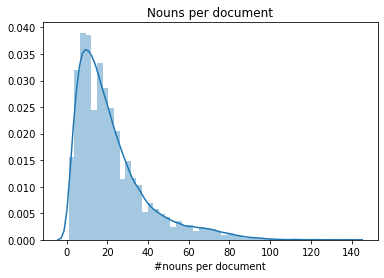

In [122]:
cmpl_nouns = cmpl_data[cmpl_data['TA_TYPE']=="noun"]
nouns_per_doc = cmpl_nouns["CMPLID"].value_counts()
ax = sns.distplot(nouns_per_doc)
ax.set(xlabel='#nouns per document')
ax.set_title('Nouns per document')
fig = ax.get_figure()

In [162]:
cmpl_nouns = cmpl_data[cmpl_data['TA_TYPE']=="noun"]
cmpl_nouns.groupby('CMPLID')['TA_TOKEN'].value_counts()

CMPLID   TA_TOKEN
68       BUCKLE      1
         CHILD       1
         SEAT        1
         SHIELD      1
         STICKS      1
                    ..
1478501  THREADS     1
         VIDEO       1
         VIEW        1
         WRANGLER    1
         WWW         1
Name: TA_TOKEN, Length: 1687025, dtype: int64

In [163]:
def get_tokencount_per_document(doc_id, df):
    cmpl_nouns = df[df['TA_TYPE']=="noun"]
    cmpl_id = cmpl_nouns[cmpl_nouns['CMPLID'] == doc_id]
    return cmpl_id['TA_TOKEN'].value_counts()

In [164]:
get_tokencount_per_document(68, cmpl_data)

TEE       1
SHIELD    1
BUCKLE    1
CHILD     1
SEAT      1
STICKS    1
Name: TA_TOKEN, dtype: int64

## Aufgabe 2 

### Size of Lexica

In [ ]:
cmpl_data['TA_TOKEN'].nunique()

In [ ]:
cmpl_data['TA_NORMALIZED'].nunique()

### Size of Lexica without punctuation and stopwords

In [ ]:
def remove_unneeded_token_types(data):
    TA_TYPES_TO_REMOVE = set({'punctuation', 'number'})
    return data[~data['TA_TYPE'].isin(TA_TYPES_TO_REMOVE)]

def remove_stopwords(data):
    nltk.download('stopwords')
    english_stopwords = set(stopwords.words('english'))
    data['TA_TOKEN_LOW'] = data['TA_TOKEN'].map(lambda row: str(row).lower())
    return data[~data['TA_TOKEN_LOW'].isin(english_stopwords)]

In [ ]:
cmpl_data_no_uneeded_tokens = remove_unneeded_token_types(cmpl_data)
cmpl_data_no_uneeded_tokens['TA_TOKEN'].nunique()

In [ ]:
cmpl_data_no_stopwords_no_uneeded_tokens = remove_stopwords(cmpl_data_no_uneeded_tokens)
cmpl_data_no_stopwords_no_uneeded_tokens['TA_TOKEN'].nunique()

### Size of Lexica after Stemming
Das Anwenden von Stemming verringert die Größe des Lexikons von 71556 auf 63690, also um rund 11%.

In [ ]:
stemmer = Cistem()
cmpl_data['TA_STEMMED'] = cmpl_data['TA_NORMALIZED'].map(lambda token: stemmer.stem(str(token)))
cmpl_data['TA_STEMMED'].nunique()

### Mean Document / Sentence length

In [ ]:
mean_doc_length = cmpl_data["CMPLID"].value_counts().mean()
mean_doc_length

In [ ]:
mean_sentence_length = cmpl_data.groupby("CMPLID")["TA_SENTENCE"].value_counts().mean()

In [ ]:
mean_sentence_length

# Tokenization (obsolete)

In [ ]:
nltk.download('punkt')

In [ ]:
t3n_data_tokenized = t3n_data
t3n_data_tokenized['text'] = t3n_data_tokenized.apply(lambda row: nltk.word_tokenize(str(row['text'])), axis=1)
t3n_data_tokenized['teaser'] = t3n_data_tokenized.apply(lambda row: nltk.word_tokenize(str(row['teaser'])), axis=1)
t3n_data_tokenized['heading'] = t3n_data_tokenized.apply(lambda row: nltk.word_tokenize(str(row['heading'])), axis=1)

In [ ]:
for index, row in t3n_data.iterrows():
    print(row['heading'])